## Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install ortools

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

import seaborn as sns
import pylab
sns.set_theme(style="darkgrid")


np.set_printoptions(suppress=True)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BusinessApplication/Final_Project/data.csv')

## Explore data analysis

In [ ]:
data.columns

Index(['srch_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score', 'prop_accesibility_score',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_booking_window', 'srch_adults_count', 'srch_children_count',
       'srch_room_count', 'srch_saturday_night_bool', 'booking_bool'],
      dtype='object')

In [ ]:
print(f'There are {data.srch_id.nunique()} unique search query.')
print(f'Among those, {data[data.booking_bool == 1].srch_id.nunique()}({data[data.booking_bool == 1].srch_id.nunique()/data.srch_id.nunique()}) are with booked.')
average_hotel_display = data.groupby('srch_id').prop_starrating.count().mean()
print(f'in average, {average_hotel_display} hotels option are shown')
print(f'Total Revenue is {data[data.booking_bool == 1].price_usd.sum()}')

There are 8354 unique search query.
Among those, 5848(0.7000239406272444) are with booked.
in average, 18.31565717021786 hotels option are shown
Total Revenue is 724462


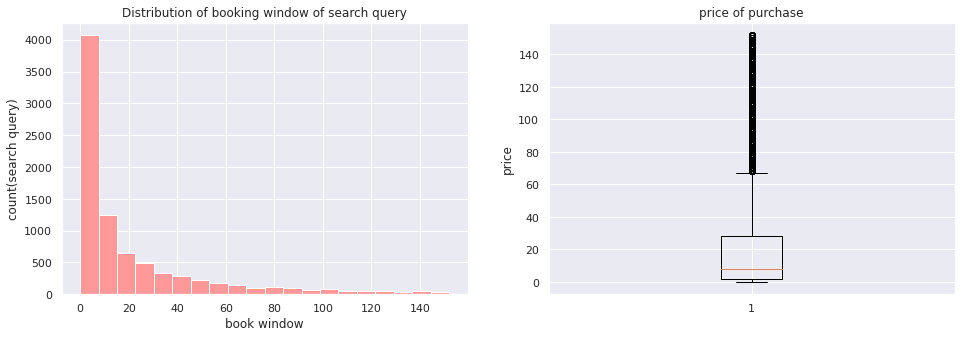

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(121)
booking_window_unique = [i[0] for i in data.groupby('srch_id').srch_booking_window.unique().tolist()]
_ = plt.hist(booking_window_unique,bins=20,color =['#ff9999'])
plt.title('Distribution of booking window of search query')
plt.xlabel('book window')
_ = plt.ylabel('count(search query)')

plt.subplot(122)
price_unique = [i[0] for i in data[data.booking_bool==1].groupby('srch_id').price_usd.unique().tolist()]
_ = plt.boxplot(booking_window_unique)
plt.title('price of purchase')
_ = plt.ylabel('price')

In [ ]:
data.sort_values(by='price_usd', ascending=False).head(10)

,srch_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score,prop_accesibility_score,prop_log_historical_price,price_usd,promotion_flag,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,booking_bool,type
151252,663681,4,5,1,1,0,5,7166,0,0,2,0,1,0,0,two_adult_late_book
151251,663681,4,4,1,3,0,5,5872,0,0,2,0,1,0,0,two_adult_late_book
133671,645117,3,4,0,0,0,4,4608,0,99,2,0,1,1,0,two_adult_early_book
130465,641489,5,4,1,3,0,6,4433,1,23,2,0,1,0,0,two_adult_early_book
133663,645117,4,5,1,4,0,5,4425,0,99,2,0,1,1,0,two_adult_early_book
151246,663681,4,4,1,3,0,5,4419,0,0,2,0,1,0,0,two_adult_late_book
151263,663681,4,3,0,4,0,5,3883,0,0,2,0,1,0,0,two_adult_late_book
151249,663681,4,3,0,4,0,5,3621,0,0,2,0,1,0,0,two_adult_late_book
151248,663681,4,4,0,4,0,5,3263,0,0,2,0,1,0,0,two_adult_late_book
69396,416136,4,5,1,5,0,6,3243,0,12,2,0,1,0,0,two_adult_early_book


In [ ]:
print(set(data[data.price_usd > 10000].srch_id.tolist()))
data = data[(data.srch_id != 562932) & (data.srch_id != 637207)]

{562932, 637207}


Text(0, 0.5, '')

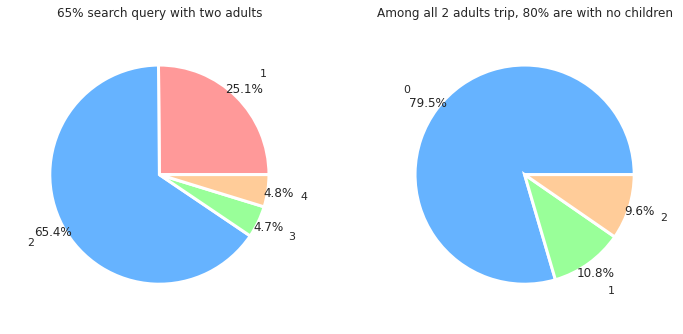

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)

df1 = data.groupby(['srch_adults_count']).agg(Distribution = ('srch_id', 'count'))
df1['Distribution']=df1['Distribution'].astype(int)

plt.title('65% search query with two adults',fontsize=12)
_ =df1['Distribution'].plot.pie(autopct='%1.1f%%',colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99'],
                                radius=0.9, pctdistance=1.1, labeldistance=1.3,
                                wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
pylab.ylabel('')

plt.subplot(122)
df1 = data[data.srch_adults_count == 2].groupby(['srch_children_count']).agg(Distribution = ('srch_id', 'count'))
df1['Distribution']=df1['Distribution'].astype(int)

plt.title('Among all 2 adults trip, 80% are with no children',fontsize=12)
_ =df1['Distribution'].plot.pie(autopct='%1.1f%%',colors = ['#66b3ff','#99ff99','#ffcc99'],
                                radius=0.9, pctdistance=1.1, labeldistance=1.3,
                                wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
pylab.ylabel('')

## Segment Search Query

In [ ]:
one_adult_early_book = data[(data['srch_adults_count'] == 1) & (data['srch_booking_window'] > 7)]
one_adult_late_book = data[(data['srch_adults_count'] == 1) & (data['srch_booking_window'] <= 7)]

two_adult_early_book = data[(data['srch_adults_count'] == 2) & (data['srch_children_count'] == 0) & (data['srch_booking_window'] > 7)]
two_adult_late_book = data[(data['srch_adults_count'] == 2) & (data['srch_children_count'] == 0) & (data['srch_booking_window'] <= 7)]

two_adult_early_book_with_children = data[(data['srch_adults_count'] == 2) & (data['srch_children_count'] > 0) & (data['srch_booking_window'] > 7)]
two_adult_late_book_with_children = data[(data['srch_adults_count'] == 2) & (data['srch_children_count'] >0) & (data['srch_booking_window'] <= 7)]


more_adult_early_book = data[(data['srch_adults_count'] > 2) & (data['srch_booking_window'] > 7)]
more_adult_late_book = data[(data['srch_adults_count'] > 2) & (data['srch_booking_window'] <= 7)]

print(len(set(one_adult_early_book.srch_id)), len(set(one_adult_late_book.srch_id)))
print(len(set(two_adult_early_book.srch_id)), len(set(two_adult_late_book.srch_id)))
print(len(set(two_adult_early_book_with_children.srch_id)), len(set(two_adult_late_book_with_children.srch_id)))
print(len(set(more_adult_early_book.srch_id)), len(set(more_adult_late_book.srch_id)))

894 1236
2252 2070
650 482
489 279


In [ ]:
# Since more adultstend to book earlier, I decide to combine this two group together
more_adult = data[data.srch_adults_count > 2]

In [ ]:
# check if the segmentation valid
print('Total number of original dataset', len(data))
print('Total number of five groups', len(one_adult_early_book) + len(one_adult_late_book) + len(two_adult_early_book) + len(two_adult_late_book) + len(two_adult_early_book_with_children) + len(two_adult_late_book_with_children) + len(more_adult))

Total number of original dataset 152954
Total number of five groups 152954


In [ ]:
def remove_price_outlier(data_seg):
    data_book_seg = data_seg[data_seg.booking_bool == 1].copy()
    data_book_seg = data_book_seg[data_book_seg.price_usd.between(0, data_book_seg.price_usd.quantile(.95))]
    output = data_seg[data_seg.srch_id.isin(data_book_seg.srch_id.unique().tolist())]
    return output

In [ ]:
# one_adult_early_book = remove_price_outlier(one_adult_early_book)
# one_adult_late_book = remove_price_outlier(one_adult_late_book)
# two_adult_early_book = remove_price_outlier(two_adult_early_book)
# two_adult_late_book = remove_price_outlier(two_adult_late_book)
# two_adult_early_book_with_children = remove_price_outlier(two_adult_early_book_with_children)
# two_adult_late_book_with_children = remove_price_outlier(two_adult_late_book_with_children)
# more_adult = remove_price_outlier(more_adult)

In [ ]:
def label_type (row):
   if row['srch_adults_count'] == 1 and  row['srch_booking_window'] > 7:
      return 'one_adult_early_book'
   if row['srch_adults_count'] == 1 and  row['srch_booking_window'] <= 7:
      return 'one_adult_late_book'
   if row['srch_adults_count'] == 2 and  row['srch_children_count'] == 0 and row['srch_booking_window'] > 7:
      return 'two_adult_early_book'
   if row['srch_adults_count'] == 2 and  row['srch_children_count'] == 0 and row['srch_booking_window'] <= 7:
      return 'two_adult_late_book '
   if row['srch_adults_count'] == 2 and  row['srch_children_count'] > 0 and row['srch_booking_window'] > 7:
      return 'two_adult_early_book_with_children'
   if row['srch_adults_count'] == 2 and  row['srch_children_count'] > 0 and row['srch_booking_window'] <= 7:
      return 'two_adult_late_book_with_children'
   if row['srch_adults_count'] > 2:
      return 'more_adult'
   return 'Other'

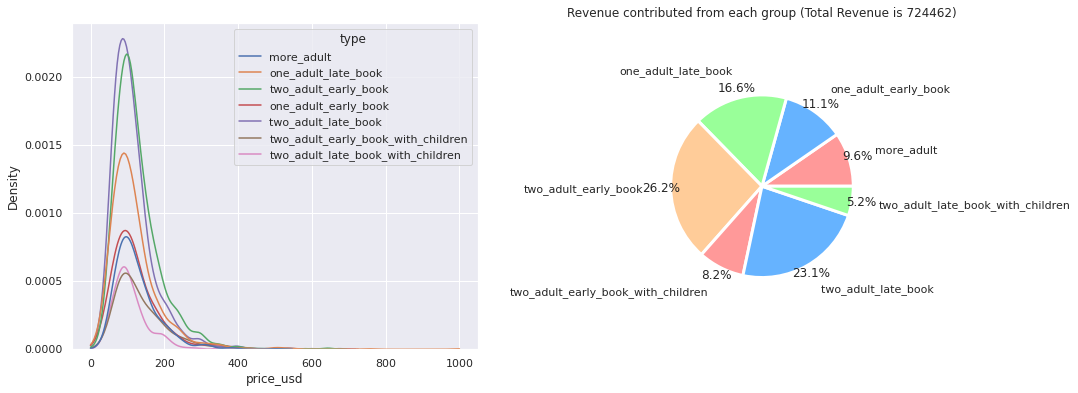

In [ ]:

plt.figure(figsize=(16,6))

plt.subplot(121) 
data_with_type = data.copy()
data_with_type['type'] = data_with_type.apply (lambda row: label_type(row), axis=1)
g = sns.kdeplot(data=data_with_type[data_with_type.booking_bool == 1], x="price_usd", hue='type',clip=(0, 1000))


plt.subplot(122) 

df = data[data.booking_bool==1].groupby('type').agg(Revenue = ('price_usd', 'sum'))
_ =df['Revenue'].plot.pie(autopct='%1.1f%%',colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99'],
                          radius=0.7, pctdistance=1.1, labeldistance=1.3,
                          wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
pylab.ylabel('')
_ = plt.title('Revenue contributed from each group (Total Revenue is 724462)')


## Apply Multinomial Logit Model

#### MNL is one of the foundamental choice model was proposed by McFodder in 1970.

#### If we offer set S, P(j|S) is the probability that customer select j: $\sum_{j=1}^n P(j|S) + P(0|S) = 1$

We define a preference weight for each product.
$v_j$:prefernce weight for product i \\
$v_o$:prefernce weight of non-purchcase 

$P(j|S) = \frac{v_j}{v_o+\sum_{S}v_i}$ = $\frac{v_j}{1+\sum_{S}v_i}$;  $P(o|S)$ = $\frac{1}{1+\sum_{S}v_i}$

Under MNL: 

v_j = $e^{u_j}$ \\
u_j: utility of product j, which is estimated as a linear function of the features of product j: $u_j$ = $\beta_0$ + $\sum_{i=1}^k\beta_ix_{ji}$






To solve for $\beta$, apply Maximum Likelihood:
**Max$\sum_{t=1}^{T}logP(j_t|S_t)$**

Impleted as below



In [ ]:
def mle(w):
    global norm_data, book_data
    obj1 = 0 
    obj2 = 0
    features = norm_data.columns[1:9].tolist()

    obj1 = w[0] * book_data.shape[0]
    for i in range(len(features)):
        sum_features = sum(book_data[features[i]])
        obj1 += sum_features * w[i+1]
    data_features = norm_data[norm_data.columns[1:9].tolist()].values
    obj2 = np.sum([np.log( 1+ np.sum([np.exp(w[0] + np.sum([w[i+1] * data_features[j][i] for i in range(8)])) for j in range(len(data_features))] )) for data_features in data_features_list])
    return - (obj1-obj2)

In [ ]:
scaler = StandardScaler()
scaler.fit(data[data.columns[1:9].tolist()])
def normalize_data(data):
    norm_data = data.copy()
    norm_data[norm_data.columns[1:9].tolist()] = scaler.transform(data[data.columns[1:9].tolist()])
    book_data = norm_data[norm_data.booking_bool == 1]
    features = norm_data.columns[1:9].tolist()
    data_features = norm_data.groupby('srch_id')[norm_data.columns[1:9].tolist()].apply(lambda g: g.values.tolist()).to_dict()
    data_features_list = []
    for key, val in data_features.items():
        data_features_list.append(val)
    return norm_data, book_data,features,data_features_list

#### $\beta$ for One Adult Early Book 
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-1.65687691 & 0.39322619 & 0.13534746& 0.14898454 & 0.04693975 & 0.03907592&
 -0.0987592 & -0.84834117 & 0.14000788 \\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(one_adult_early_book)
res = minimize(mle, np.ones((9,)), method="BFGS")

CPU times: user 1min 27s, sys: 224 ms, total: 1min 28s
Wall time: 1min 28s


In [ ]:
print(res.x)
beta1 = res.x

[-1.65687691  0.39322619  0.13534746  0.14898454  0.04693975  0.03907592
 -0.0987592  -0.84834117  0.14000788]


#### $\beta$ for One Adult Late Book 
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-1.09515076  &0.47160355 & 0.03070543&  0.16362486&  0.11890095  &0.01179536&
 -0.01737279& -0.8929924 &  0.14899753\\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(one_adult_late_book)
res = minimize(mle, np.ones((9,)), method="BFGS")

CPU times: user 4min 36s, sys: 579 ms, total: 4min 37s
Wall time: 4min 37s


In [ ]:
print(res.x)
beta2 = res.x

[-1.09515076  0.47160355  0.03070543  0.16362486  0.11890095  0.01179536
 -0.01737279 -0.8929924   0.14899753]


#### $\beta$ for Two Adult Early Book
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-2.05114188 &  0.43516234 & 0.10855248 & 0.07264858 &-0.01034439 & 0.06280207&
 -0.04934801& -0.82423012 & 0.13408575] \\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(two_adult_early_book)
res = minimize(mle, np.ones((9,)), method="BFGS")

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


CPU times: user 8min 10s, sys: 1.01 s, total: 8min 11s
Wall time: 8min 11s


In [ ]:
print(res.x)
beta3 = res.x

[-2.05114188  0.43516234  0.10855248  0.07264858 -0.01034439  0.06280207
 -0.04934801 -0.82423012  0.13408575]


#### $\beta$ for Two Adult Late Book
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-1.77425393 & 0.46584541 & 0.13045475 & 0.11199533 & 0.02774621 & 0.02587196&
  0.04161532& -1.070673  &  0.20968664\\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(two_adult_late_book)
res = minimize(mle, np.ones((9,)), method="BFGS")

CPU times: user 3min 38s, sys: 442 ms, total: 3min 38s
Wall time: 3min 39s


In [ ]:
print(res.x)
beta4 = res.x

[-1.77425393  0.46584541  0.13045475  0.11199533  0.02774621  0.02587196
  0.04161532 -1.070673    0.20968664]


#### $\beta$ for two_adult_early_book_with_children
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-1.96615172 & 0.3394144 &   0.22477716&  0.16317336& -0.02526133&  0.08379253&
 -0.25975851& -0.60556229  &0.05295875 \\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(two_adult_early_book_with_children)
res = minimize(mle, np.ones((9,)), method="BFGS")

CPU times: user 1min 24s, sys: 199 ms, total: 1min 24s
Wall time: 1min 24s


In [ ]:
print(res.x)
beta5 = res.x

[-1.96615172  0.3394144   0.22477716  0.16317336 -0.02526133  0.08379253
 -0.25975851 -0.60556229  0.05295875]


#### $\beta$ for two_adult_late_book_with_children
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-1.81656813  &0.53136945 & 0.12846492 & 0.07999609& -0.00769564&  0.05857278&
 -0.20825877& -1.33673477 & 0.23217329\\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(two_adult_late_book_with_children)
res = minimize(mle, np.ones((9,)), method="BFGS")

CPU times: user 2min 56s, sys: 375 ms, total: 2min 56s
Wall time: 2min 56s


In [ ]:
print(res.x)
beta6 = res.x

[-1.81656813  0.53136945  0.12846492  0.07999609 -0.00769564  0.05857278
 -0.20825877 -1.33673477  0.23217329]


#### $\beta$ for more_adult
\begin{array}{ccc}
\beta_0 & \beta_1 & \beta_2 & \beta_3 & \beta_4 & \beta_5 & \beta_6 & \beta_7 & \beta_8 \\
\text{No Purchase} & \text{Star Rating} & \text{Review Score} & \text{Hotel Brand} & \text{Location Score} & \text{Accessibility Score} & \text{Historical Price} & \text{Displayed Price} & \text{Promotion Flag}\\
-1.61299133&  0.44489648 & 0.21437708 &-0.03209845 & 0.10848731 & 0.05663473&
 -0.04018944& -1.2135436 &  0.16383835\\
\end{array}

In [ ]:
%%time
norm_data, book_data,features,data_features_list = normalize_data(more_adult)
res = minimize(mle, np.ones((9,)), method="BFGS")

CPU times: user 1min 31s, sys: 204 ms, total: 1min 31s
Wall time: 1min 31s


In [ ]:
print(res.x)
beta7 = res.x

[-1.61299133  0.44489648  0.21437708 -0.03209845  0.10848731  0.05663473
 -0.04018944 -1.2135436   0.16383835]


## Analyze segment sensitivity

In [ ]:
beta_df = valor_ano = pd.DataFrame({'one_adult_early_book':beta1, 
                         'one_adult_late_book':beta2,
                         'two_adult_early_book':beta3,
                         'two_adult_late_book':beta4,
                         'two_adult_early_book_with_children':beta5,
                         'two_adult_late_book_with_children':beta6,
                         'more_adult': beta7})
beta_df = beta_df.T
col_name =  data.columns[1:9].tolist()
col_name.insert(0, "beta0")
beta_df.columns = col_name
beta_df = beta_df.drop("beta0",axis=1)
beta_df = beta_df.reset_index().melt('index', var_name='cols',  value_name='vals')
beta_df.columns = ['type','features','score']

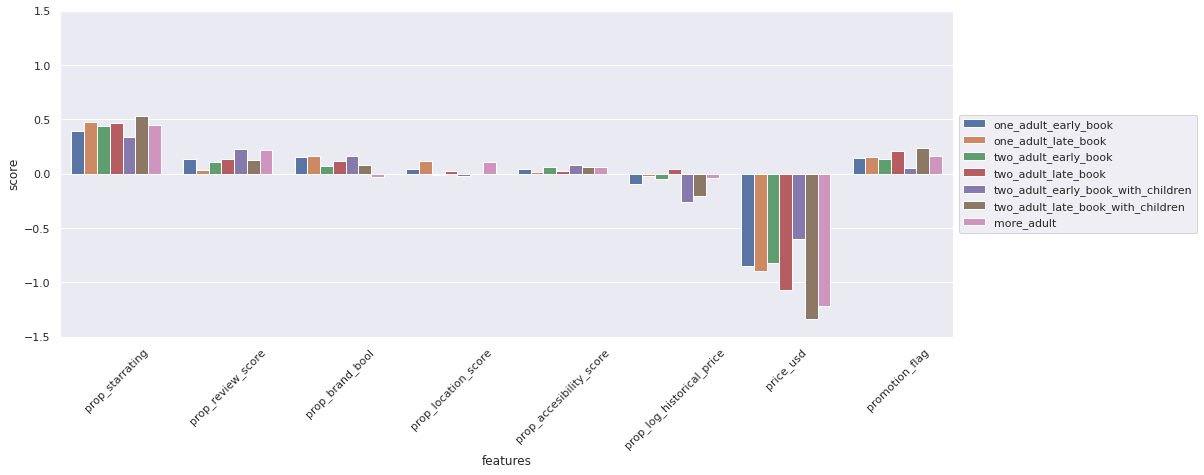

In [ ]:
# @title Customer Sensitivity on 8 Features
# @markdown According to the plot, we can see that 'star rating', 'price', 'promotion flag' are three most import features for customer to make purchase decision.

# @markdown 'star rating' and price' are three most importance features for customer deicision making.

# @markdown the family trip booking early are most distinct type of customer that they care less about star rating, price and promotion but look at the review and historical price

# @markdown Customer make booking late(within 7 days) tend to care more about the star rating, price and promotion, the more straightfoward features of the hotel. 

# @markdown Genrally, early book people are more flexible on the price
plt.figure(figsize=(16,6))
plt.ylim(-1.5,1.5)
plt.xticks(rotation=45)
g = sns.barplot(data=beta_df, x="features", y="score", hue='type')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Assortment Optimization
#### Under the MNL, the expected revenue of associated S is 
R(S) = $\sum_{S}p_jP(j|S)$ = $\frac{\sum_{S}p_jv_j}{1+\sum_Sv_i}$
To solve the assorment optimization problem, we want to solve `MAX R(S)`




Theorem: Under MNL model, the optimal assortment is "nested by price", i.e., is of the form {1,2,...,j} for some j belongs to {1,2,...,n}

In [ ]:
# @markdown Assumed we are given a list of 27 available hotels, we try to sell them to each type of the customers
data1 = pd.read_csv('/content/drive/MyDrive/BusinessApplication/Final_Project/data4.csv')
print(f'Assume we are give a list of {data1.shape[0]} hotels')
data1.head()

Assume we are give a list of 27 hotels


,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score,prop_accesibility_score,prop_log_historical_price,price_usd,promotion_flag
0,4,5,0,3,0,0,71,1
1,3,4,0,3,0,0,45,0
2,4,5,0,3,0,0,92,1
3,4,4,1,2,0,0,152,1
4,4,5,0,2,0,0,195,1


In [ ]:
scaler = StandardScaler()
scaler.fit(data[data.columns[1:9].tolist()])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
def sort_price(data):
    data_sort=data.sort_values(by='price_usd', ascending = False)
    return data_sort

# normalize data
def normalize_data(data):
    data=sort_price(data)
    global scaler
    # scaler = StandardScaler()
    data_arr= scaler.fit_transform(data)
    return data_arr
def assortment (data, w):
    data=sort_price(data)
    data_arr=normalize_data(data)
    # beta values
    # w=[-1.74662561,0.4081257,0.10876137, 0.10138233,0.0220258,0.04344385, -0.06686915, -1.33111708,0.15977632]
    #u
    u=[0 for i in range (len(data_arr))]
    for i in range (len(data_arr)):
        u[i]+=w[0]
        for k in range (8):
            u[i]+= w[k+1] * data_arr[i][k]

    # v
    v=[np.exp(u[i]) for i in range (len(data_arr))]

    # p
    p=data['price_usd'].tolist()

    possible=[i for i in range(len(data_arr))]
    #possible combinmation
    group=[]
    for i in possible:
        group.append(possible[:i+1])

    sum=[0 for i in range(len(data_arr))]

    for i in range (len(data_arr)):
        upper=0
        lower=1
        for j in group[i]:
            upper+=p[j]*v[j]
            lower+=v[j]

        sum[i]=upper/lower
    # print(sum)

    index=sum.index(max(sum))
    print('The highest expected revenue is:', max(sum))
    print('The assortment is',list(data[:index].index))
    print(f'Total {index} hotels should display to achieve the max price')
    return list(data[:index].index), max(sum), data[:index]

In [ ]:
assortment1, r1, detial1 = assortment(data1, beta1)
assortment2, r2, detial2 = assortment(data1, beta2)
assortment3, r3, detial3 = assortment(data1, beta3)
assortment4, r4, detial4 = assortment(data1, beta4)
assortment5, r5, detial5 = assortment(data1, beta5)
assortment6, r6, detial6 = assortment(data1, beta6)
assortment7, r7, detial7 = assortment(data1, beta7)

The highest expected revenue is: 73.63178804760346
The assortment is [4, 3, 20, 21, 19, 26, 15, 6, 10, 18, 8, 2, 23, 7]
Total 14 hotels should display to achieve the max price
The highest expected revenue is: 83.9338719145546
The assortment is [4, 3, 20, 21, 19, 26, 15, 6, 10, 18, 8, 2, 23]
Total 13 hotels should display to achieve the max price
The highest expected revenue is: 66.13628193720481
The assortment is [4, 3, 20, 21, 19, 26, 15, 6, 10, 18, 8, 2, 23, 7, 9, 0]
Total 16 hotels should display to achieve the max price
The highest expected revenue is: 69.69352128535344
The assortment is [4, 3, 20, 21, 19, 26, 15, 6, 10, 18, 8, 2, 23, 7, 9]
Total 15 hotels should display to achieve the max price
The highest expected revenue is: 70.34789206390803
The assortment is [4, 3, 20, 21, 19, 26, 15, 6, 10, 18, 8, 2, 23, 7, 9]
Total 15 hotels should display to achieve the max price
The highest expected revenue is: 67.2075661757774
The assortment is [4, 3, 20, 21, 19, 26, 15, 6, 10, 18, 8, 2, 

In [ ]:
E_Revenue = r1+r2+r3+r4+r5+r6+r7
print(f'The total expecte revenue with this list of hotels is {E_Revenue}')

The total expecte revenue with this list of hotels is 501.24124089252666


### Price optimization

In [ ]:
def find_price(hotel, w):
    # drop price column
    # normalize data


    beta_p= w[-2]
    beta= np.delete(w, -2)

    #price mean, std
    price = hotel.price_usd.tolist()
    price_mean = np.mean(price)
    price_std = np.std(price)
    scaler = StandardScaler()
    scaler.fit(data[data.columns[1:9].tolist()])
    data_ = scaler.transform(hotel)
    data_alpha=np.delete(data_,[6], axis = 1)

    def rev(p):
        first=0
        second=1
        
        for j in range(len(p)):
            alpha=0
            for k in range(7):
                alpha+=beta[k+1]*data_alpha[j][k]

            first+= (p[j]*price_std + price_mean)*np.exp((beta[0]+alpha-1.33111708*p[j]))
            second+= np.exp(beta[0]+alpha-1.33111708*p[j])

        obj = np.log(first)-np.log(second)
        return -obj

    result = minimize(rev, np.random.rand(data_alpha.shape[0],), method="BFGS")
    res=result.x*price_std + price_mean
    print('optimal prices',res)
    print('Expected revenue is:',np.exp(-result.fun))

In [ ]:
# @markdown The price is all the same because we dont count in the cost of hotel room
find_price(data1, beta1)

optimal prices [113.6138864  113.6536003  113.61222423 113.62745369 113.6133133
 113.6210865  113.62409698 113.61882629 113.62441038 113.60913577
 113.60703376 113.60307552 113.64409767 113.60201164 113.65284083
 113.60102811 113.57696358 113.62682812 113.58628227 113.62757966
 113.6094149  113.6173052  113.61204753 113.60708799 113.62971447
 113.59567402 113.6169394 ]
Expected revenue is: 85.87307925472464


## Conclusion